<a href="https://colab.research.google.com/github/Youhanna-Yousry/Speech-Emotion-Recognition/blob/master/SpeechEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition


## Problem statement
Speech is the most natural way of expressing ourselves as humans. It is only natural
then to extend this communication medium to computer applications. We define
speech emotion recognition (SER) systems as a collection of methodologies that
process and classify speech signals to detect the embedded emotions. Below we will
show the needed steps to achieve the goal of the assignment.
[assignment link](https://github.com/Youhanna-Yousry/Speech-Emotion-Recognition/blob/master/assets/CSE352_Assignment_3.pdf)

## Imports

In [ ]:
from google.colab import files, drive
from os import path, listdir

import librosa
from re import split

import matplotlib.pyplot as plt
import numpy as np

# sklearn imported function
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# seaborn imported functions
import seaborn as sns

# keras imported functions
from keras import regularizers, optimizers, backend
from keras.models import Sequential, load_model
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

from gc import collect

In [ ]:
np.random.seed(42)

## 1.Downloading the dataset and understanding its format

### Downloading dataset
The [SER dataset](https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en) is downloaed using Kaggle api [article link](https://www.kaggle.com/general/156610)


In [ ]:
# kaggle api setup

# token uploading
kaggle_token_file = 'kaggle.json'
if not path.exists(kaggle_token_file):
  files.upload()

# creating a directory for kaggle and give permission to the json file
kaggle_direcotry = '~/.kaggle/'
if not path.exists(kaggle_direcotry):
  !mkdir -p {kaggle_direcotry}
  !cp kaggle.json {kaggle_direcotry}
  !chmod 600 {kaggle_direcotry}kaggle.json

# downloading zipped dataset
dataset_zipped_file = 'speech-emotion-recognition-en.zip'
if not path.exists(dataset_zipped_file):
  !kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

# unzipping dataset
dataset_direcotry = '/dataset'
if not path.exists(dataset_direcotry):
  !unzip speech-emotion-recognition-en.zip -d {dataset_direcotry}

dataset_direcotry = path.join(dataset_direcotry, 'Crema')

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/Crema/1088_IWW_FEA_XX.wav  
  inflating: /dataset/Crema/1088_IWW_HAP_XX.wav  
  inflating: /dataset/Crema/1088_IWW_NEU_XX.wav  
  inflating: /dataset/Crema/1088_IWW_SAD_XX.wav  
  inflating: /dataset/Crema/1088_MTI_ANG_XX.wav  
  inflating: /dataset/Crema/1088_MTI_DIS_XX.wav  
  inflating: /dataset/Crema/1088_MTI_FEA_XX.wav  
  inflating: /dataset/Crema/1088_MTI_HAP_XX.wav  
  inflating: /dataset/Crema/1088_MTI_NEU_XX.wav  
  inflating: /dataset/Crema/1088_MTI_SAD_XX.wav  
  inflating: /dataset/Crema/1088_TAI_ANG_XX.wav  
  inflating: /dataset/Crema/1088_TAI_DIS_XX.wav  
  inflating: /dataset/Crema/1088_TAI_FEA_XX.wav  
  inflating: /dataset/Crema/1088_TAI_HAP_XX.wav  
  inflating: /dataset/Crema/1088_TAI_NEU_XX.wav  
  inflating: /dataset/Crema/1088_TAI_SAD_XX.wav  
  inflating: /dataset/Crema/1088_TIE_ANG_XX.wav  
  inflating: /dataset/Crema/1088_TIE_DIS_XX.wav  
  inflating: /dataset/Crema/1088_TIE_FEA_XX.wav  

### Filename labeling conventions

The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).

Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):

- It's eleven o'clock (IEO).
- That is exactly what happened (TIE).
- I'm on my way to the meeting (IOM).
- I wonder what this is about (IWW).
- The airplane is almost full (TAI).
- Maybe tomorrow it will be cold (MTI).
- I would like a new alarm clock (IWL)
- I think I have a doctor's appointment (ITH).
- Don't forget a jacket (DFA).
- I think I've seen this before (ITS).
- The surface is slick (TSI).
- We'll stop in a couple of minutes (WSI).

The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

- Anger (ANG)
- Disgust (DIS)
- Fear (FEA)
- Happy/Joy (HAP)
- Neutral (NEU)
- Sad (SAD)

and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

- Low (LO)
- Medium (MD)
- High (HI)
- Unspecified (XX)

The suffix of the filename is based on the type of file, flv for flash video used for presentation of both the video only, and the audio-visual clips. mp3 is used for the audio files used for the audio-only presentation of the clips. wav is used for files used for computational audio processing.

Source: [CREMA-D github repo](https://github.com/CheyneyComputerScience/CREMA-D)

In this function we load the audio files using librosa after that we use zero padding to make all audio signal arrays have the same structure.

Finally, we extact the labels of each audio and create the data matrix and label vectors.

In [ ]:
def generate_data(directory):
    """
    Reads audio files from the given directory and returns a matrix of audio signals
    and a vector of labels.
    """
    data_matrix = []
    label_vector = []

    max_length = 0  # Initialize maximum length to zero

    # Find the maximum length of the audio signals
    for audio in listdir(directory):
        audio_path = path.join(directory, audio)
        data, samplerate = librosa.load(audio_path, sr=None)
        max_length = max(max_length, len(data))

    # Pad all the audio signals to the maximum length
    for audio in listdir(directory):
        audio_path = path.join(directory, audio)
        data, samplerate = librosa.load(audio_path, sr=None)
        label = split(r'_+', path.basename(audio_path))[2]
        padded_data = np.pad(data, (0, max_length - len(data)), mode='constant')
        data_matrix.append(padded_data)
        label_vector.append(label)

    return np.array(data_matrix), np.array(label_vector)

Here, we assign each label a number such that {0, 1, 2, 3, 4, 5} corresponsds to ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

In [ ]:
data, labels = generate_data(dataset_direcotry)
Encoder = LabelEncoder().fit(labels)
labels = Encoder.transform(labels)

Here we pick a random audio signal from each class then plot its amplitude against time.

In [ ]:
def plot_random_unique(data, labels):
    unique_labels = np.unique(labels)

    fig, axs = plt.subplots(len(unique_labels)//2, 2, figsize=(14, 15))

    for i, label in enumerate(unique_labels):
        str_label = Encoder.inverse_transform(np.array([label]))[0]
        filtered_data = data[labels == label]
        random_index = np.random.randint(filtered_data.shape[0])

        axs[i//2, i%2].plot(np.arange(80080) / 16000, filtered_data[random_index])
        axs[i//2, i%2].set_xlabel('Time')
        axs[i//2, i%2].set_ylabel('Amplitude')
        axs[i//2, i%2].set_title(f'Random {str_label} audio')

    plt.show()

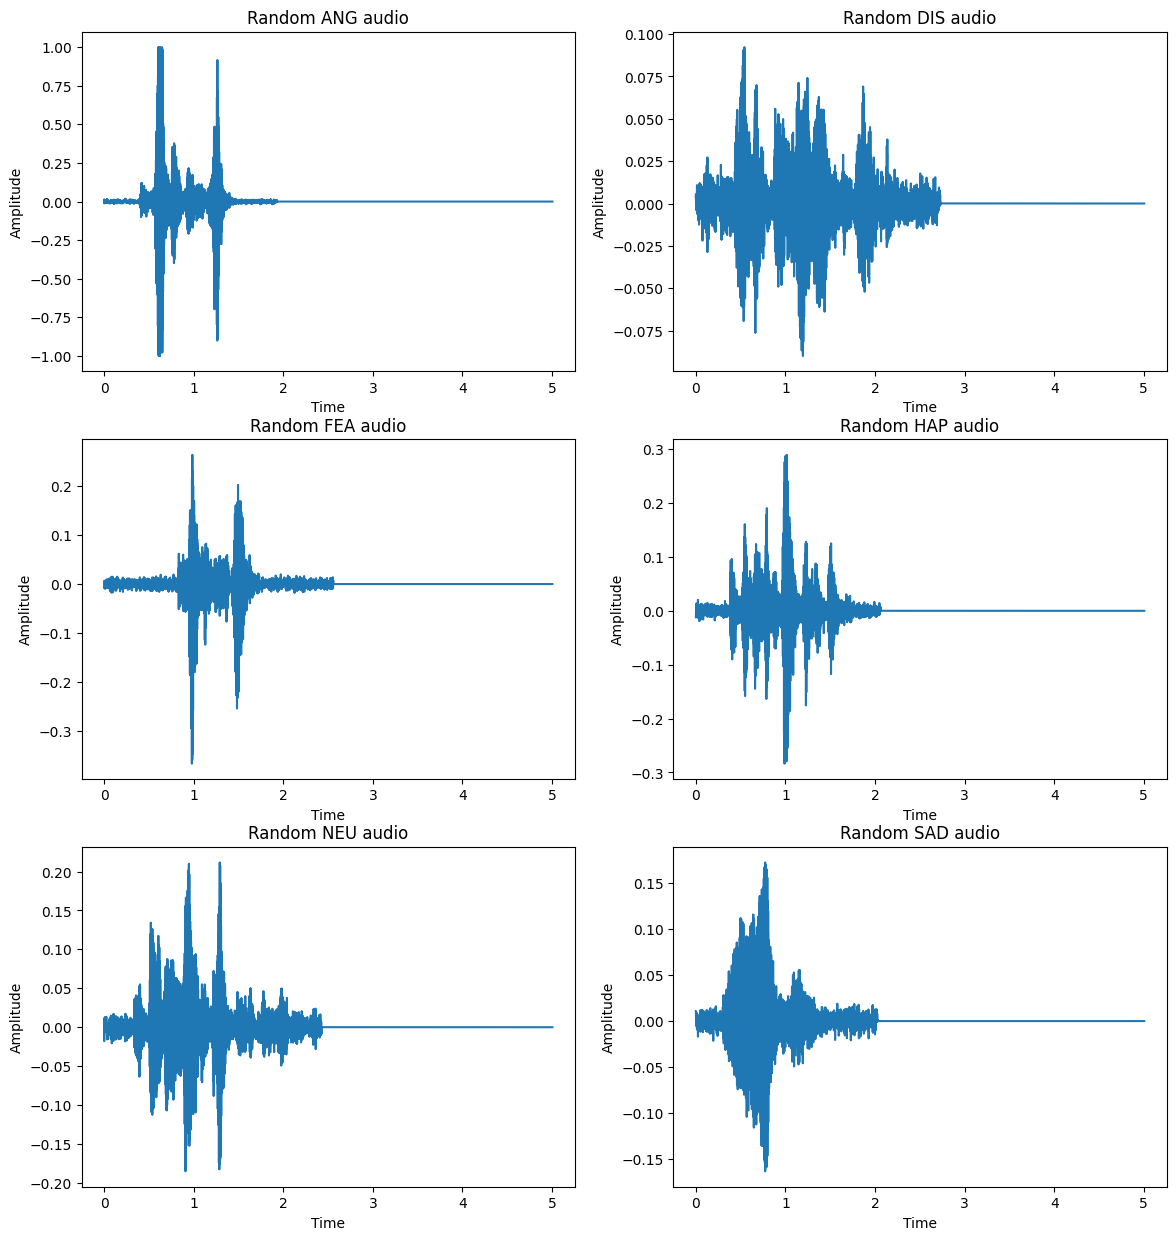

In [ ]:
plot_random_unique(data, labels)

## 2.Create the Feature Space

Here we used the audio signal in time domain to extract the zero-crossing rate and energy which are common features to characterize an audio signal.

**zero-crossing rate**: zero crossing rate represents the rate at which an audio signal changes its sign. High rate corresponds to high frequency.

**energy**: The sum of squares of the signal values, normalized by
the respective frame length.

Here we used the default parameters of librosa for both frame_length = 2048 and hop_length = 512


In [ ]:
def compute_zcr_energy(data):
  zcr = []
  energy = []
  for i in range(len(data)):
    zcr.append(librosa.feature.zero_crossing_rate(y=data[i]))
    energy.append(librosa.feature.rms(y=data[i]))

  return np.array(zcr), np.array(energy)

In [ ]:
zcr, energy = compute_zcr_energy(data)

Here we concatenate the zero-crossing rate and energy of each audio signal then create a new data matrix for both features.

In [ ]:
zcr = np.reshape(zcr, (zcr.shape[0], zcr.shape[2]))
energy = np.reshape(energy, (energy.shape[0], energy.shape[2]))
data = np.concatenate((zcr, energy), axis=1)
del zcr, energy

Here we used librosa to compute the mel spectogram for all audio signals then we convert the magnitude spectrogram to decibel scale, which provides a more meaningful representation

In [ ]:
def generate_mel_spectogram_data(data):
  mel_spectogram_data = []

  for i in range(len(data)):
      mel_signal = librosa.feature.melspectrogram(y=data[i], sr=16000, n_mels=128)
      spectrogram = librosa.power_to_db(mel_signal, ref=np.max)
      mel_spectogram_data.append(spectrogram)

  return np.array(mel_spectogram_data)

In [ ]:
mel_spectogram_data = generate_mel_spectogram_data(data)

## 3.Building the Mode

The training dataset is standradized to ensure that all features have similar scale then all dataset are scaled.

The dataset is divided into training(66.5%), testing(30%), and validation(3.5%).

In [ ]:
training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels,
                                                                                test_size=0.3, stratify=labels, random_state=42)
del data
training_data, validation_data, training_labels, validation_labels = train_test_split(training_data, training_labels,
                                                                                test_size=0.05, stratify=training_labels, random_state=42)

scaler = StandardScaler()
scaler.fit(training_data)
training_data = scaler.transform(training_data)
validation_data = scaler.transform(validation_data)
testing_data = scaler.transform(testing_data)

Dimensions of training, testing and validation data is expand to make them compatible with CNN model.

In [ ]:
training_data = np.expand_dims(training_data, axis=-1)
testing_data = np.expand_dims(testing_data, axis=-1)
validation_data = np.expand_dims(validation_data, axis=-1)

In [ ]:
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(314, 1),
           kernel_regularizer=regularizers.l2(0.1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(0.1)),
    Conv1D(filters=32, kernel_size=5, activation='relu',
           kernel_regularizer=regularizers.l2(0.1)),
    Conv1D(filters=64, kernel_size=7, activation='relu',
           kernel_regularizer=regularizers.l2(0.1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(6, activation='softmax')
])

- Sparse Categorical Cross Entropy loss function is used as we have multiclass classification task.
- Adam optimizer is used with learning rate = 0.0025.
- The accuracy metric measures the percentage of correctly predicted labels during model evaluation.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0025),
              metrics=['accuracy'])

- A callback function is used to save the model that has best valdation accuracy.
- The batch size is set to be 120.
- The number of epochs is set to be 600.

In [ ]:
filepath = "1D.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(training_data,
          training_labels,
          epochs=600,
          batch_size=120,
          validation_data=(validation_data, validation_labels),
          callbacks=[checkpoint])

Epoch 1/600
41/42 [============================>.] - ETA: 0s - loss: 5.2205 - accuracy: 0.3439
Epoch 1: val_accuracy improved from -inf to 0.33716, saving model to 1D.h5
42/42 [==============================] - 4s 34ms/step - loss: 5.2045 - accuracy: 0.3436 - val_loss: 2.2561 - val_accuracy: 0.3372
Epoch 2/600
39/42 [==========================>...] - ETA: 0s - loss: 1.9077 - accuracy: 0.3795
Epoch 2: val_accuracy improved from 0.33716 to 0.34100, saving model to 1D.h5
42/42 [==============================] - 1s 14ms/step - loss: 1.8935 - accuracy: 0.3828 - val_loss: 1.7123 - val_accuracy: 0.3410
Epoch 3/600
39/42 [==========================>...] - ETA: 0s - loss: 1.6320 - accuracy: 0.4009
Epoch 3: val_accuracy improved from 0.34100 to 0.40996, saving model to 1D.h5
42/42 [==============================] - 1s 13ms/step - loss: 1.6298 - accuracy: 0.4032 - val_loss: 1.6028 - val_accuracy: 0.4100
Epoch 4/600
41/42 [============================>.] - ETA: 0s - loss: 1.5989 - accuracy: 0.4010

Saving the best 1D model to the drive

In [ ]:
drive.mount('/content/drive')
%cp -av "/content/1D.h5" "/content/drive/MyDrive/Colab Notebooks/1D.h5"

Mounted at /content/drive
'/content/1D.h5' -> '/content/drive/MyDrive/Colab Notebooks/1D.h5'


The dataset of mel spectogram is first flattened then standradized to ensure that all features have similar scale.

The dataset is divided into training(66.5%), testing(30%), and validation(3.5%).

In [ ]:
mel_training_data, mel_testing_data, mel_training_labels, mel_testing_labels = train_test_split(mel_spectogram_data, labels,
                                                                                test_size=0.3, stratify=labels, random_state=42)
del mel_spectogram_data, labels
mel_training_data, mel_validation_data, mel_training_labels, mel_validation_labels = train_test_split(mel_training_data, mel_training_labels,
                                                                                test_size=0.05, stratify=mel_training_labels, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 157, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.05)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (5, 5), activation='relu', padding='same',  kernel_regularizer=regularizers.l2(0.05)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (7, 7), activation='relu', padding='same',  kernel_regularizer=regularizers.l2(0.05)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(0.1)),
    Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.01)),
    Dense(6, activation='softmax')
])

In [ ]:
mel_training_data = np.expand_dims(mel_training_data, axis=-1)
mel_testing_data = np.expand_dims(mel_testing_data, axis=-1)
mel_validation_data = np.expand_dims(mel_validation_data, axis=-1)

- Sparse Categorical Cross Entropy loss function is used as we have multiclass classification task.
- Adam optimizer is used with learning rate = 0.001.
- The accuracy metric measures the percentage of correctly predicted labels during model evaluation.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

- A callback function is used to save the model that has best valdation accuracy.
- The batch size is set to be 1024.
- The number of epochs is set to be 300.

In [ ]:
filepath = "2D.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(mel_training_data,
          mel_training_labels,
          epochs=300,
          batch_size=1024,
          validation_data=(mel_validation_data, mel_validation_labels),
          callbacks=[checkpoint])

Epoch 1/300
5/5 [==============================] - ETA: 0s - loss: 31.7186 - accuracy: 0.1690
Epoch 1: val_accuracy improved from -inf to 0.17241, saving model to 2D.h5
5/5 [==============================] - 3s 364ms/step - loss: 31.7186 - accuracy: 0.1690 - val_loss: 27.9417 - val_accuracy: 0.1724
Epoch 2/300
5/5 [==============================] - ETA: 0s - loss: 26.1609 - accuracy: 0.1815
Epoch 2: val_accuracy improved from 0.17241 to 0.18391, saving model to 2D.h5
5/5 [==============================] - 2s 312ms/step - loss: 26.1609 - accuracy: 0.1815 - val_loss: 23.5794 - val_accuracy: 0.1839
Epoch 3/300
5/5 [==============================] - ETA: 0s - loss: 22.2384 - accuracy: 0.1785
Epoch 3: val_accuracy did not improve from 0.18391
5/5 [==============================] - 1s 287ms/step - loss: 22.2384 - accuracy: 0.1785 - val_loss: 20.2949 - val_accuracy: 0.1686
Epoch 4/300
5/5 [==============================] - ETA: 0s - loss: 19.2700 - accuracy: 0.1710
Epoch 4: val_accuracy impro

In [ ]:
drive.mount('/content/drive')
%cp -av "/content/2D.h5" "/content/drive/MyDrive/Colab Notebooks/2D.h5"

Mounted at /content/drive
'/content/2D.h5' -> '/content/drive/MyDrive/Colab Notebooks/2D.h5'


## 4.Big Picture

Loading the saved models from google drive

In [ ]:
!gdown https://drive.google.com/uc?id=1cgE5TxT5Ha6izFIlAmPoVZzlO6EMpur9
!gdown https://drive.google.com/uc?id=1FzY7q7oZ_1-5frFQn63Q934Sl18NL43t

Downloading...
From: https://drive.google.com/uc?id=1cgE5TxT5Ha6izFIlAmPoVZzlO6EMpur9
To: /content/1D.h5
100% 3.89M/3.89M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FzY7q7oZ_1-5frFQn63Q934Sl18NL43t
To: /content/2D.h5
100% 14.2M/14.2M [00:00<00:00, 151MB/s]


In [ ]:
model1D = load_model('1D.h5')

In [ ]:
model1D.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 312, 16)           64        
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 156, 16)          0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 154, 32)           1568      
                                                                 
 conv1d_18 (Conv1D)          (None, 150, 32)           5152      
                                                                 
 conv1d_19 (Conv1D)          (None, 144, 64)           14400     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 72, 64)           0         
 1D)                                                  

In [ ]:
model2D = load_model('2D.h5')

In [ ]:
model2D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 155, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 77, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 35, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 17, 64)      

### Loss and Accuracy

1D Model

In [ ]:
model1D.evaluate(testing_data, testing_labels)

70/70 [==============================] - 1s 8ms/step - loss: 1.4425 - accuracy: 0.5087


[1.4425020217895508, 0.5087326169013977]

2D Model

In [ ]:
model2D.evaluate(mel_testing_data, mel_testing_labels)

70/70 [==============================] - 12s 163ms/step - loss: 1.2597 - accuracy: 0.6386


[1.259692907333374, 0.6386027932167053]

### Confusion matrix & F1 score

1D Model

70/70 [==============================] - 1s 13ms/step
F1 Score:  0.4962131986023916


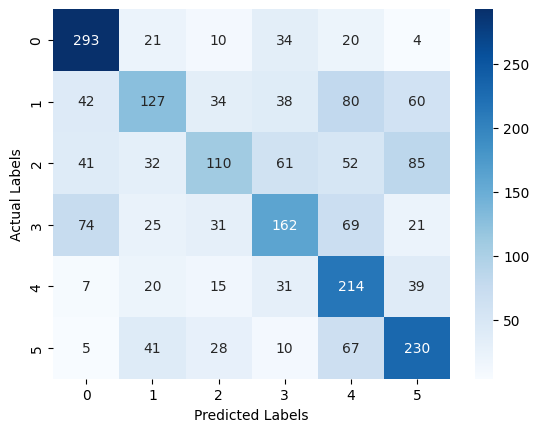

In [ ]:
y_predict = model1D.predict(testing_data)
y_pred_labels = np.argmax(y_predict, axis=1)

print("F1 Score: ", f1_score(testing_labels, y_pred_labels, average='macro'))

cm = confusion_matrix(testing_labels, y_pred_labels)
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
cm.set(xlabel='Predicted Labels', ylabel='Actual Labels')
plt.show()

Most confusing classes: (first actual, second predicted)
- Disgust and Neutral
- Fear and Sad

2D Model

70/70 [==============================] - 11s 159ms/step
F1 Score:  0.6342092358567859


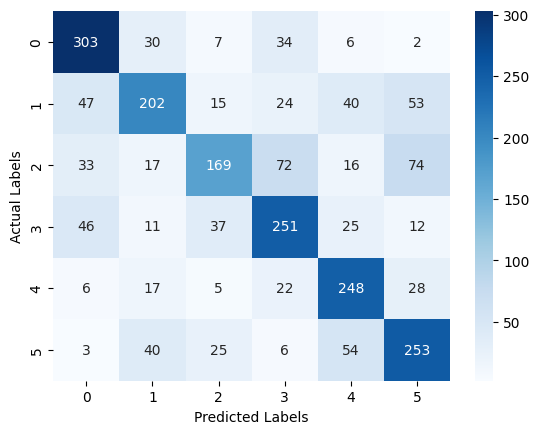

In [ ]:
y_predict = model2D.predict(mel_testing_data)
y_pred_labels = np.argmax(y_predict, axis=1)

print("F1 Score: ", f1_score(mel_testing_labels, y_pred_labels, average='macro'))

cm = confusion_matrix(mel_testing_labels, y_pred_labels)
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
cm.set(xlabel='Predicted Labels', ylabel='Actual Labels')
plt.show()

Most confusing classes: (first actual, second predicted)
- Fear and Happy
- Fear and Sad

We can notice from the accuracy, f1 score and confusion matrix, that the 2D model is better that the 1D model.
The mel spectrogram unleashes hidden features in the audio and it visualizes sounds in a way that is more relevant to how humans hear it.
Therfore, the 2D model is better.

Source: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53